# Burgers Equation

$$u_{t} = 0.1u_{xx} - 1.0uu_{x}$$

In [1]:
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import tensorflow as tf

import csv
from torch.autograd import grad
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
from pylab import figure, text, scatter, show
from pdefind import *

from Model_Identification.PDE_Equation import pde_matrix_mul, sparse_coeff, normalized_xi_threshold, pde_Recover
from Model_Identification.build_Library import construct_Dictonary
from datetime import datetime



## Data Setup


start_time: 2020-04-07 18:00:57.121904
u shape (256, 101)
x shape (256,)
t shape (101,)


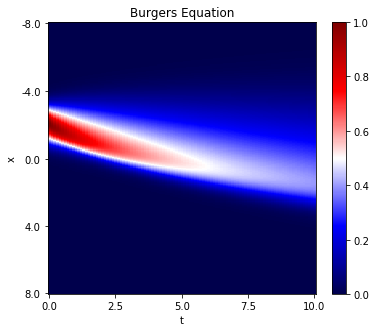

In [2]:
start_time = datetime.now()
print('start_time:', start_time)

data = sio.loadmat(os.path.join(os.getcwd(), "../data", "burgers.mat"))
u = data["usol"]
x = data["x"][0]
t = np.squeeze(data["t"], axis=1)

print("u shape", u.shape)
print("x shape", x.shape)
print("t shape", t.shape)

im = plt.imshow(u.real, cmap="seismic", aspect=0.4)
plt.colorbar(im)
plt.title("Burgers Equation")
plt.xlabel("t")
plt.ylabel("x")


xpos  = np.arange(len(t), step=25)
ypos  = np.where(x%4==0)[0].tolist()
ytick = x[ypos].tolist()
ypos  += [len(x)-1]
ytick += [8.0]

plt.xticks(xpos, t[xpos])
plt.yticks(ypos, ytick)
plt.gcf().set_size_inches(6,5)
plt.show()

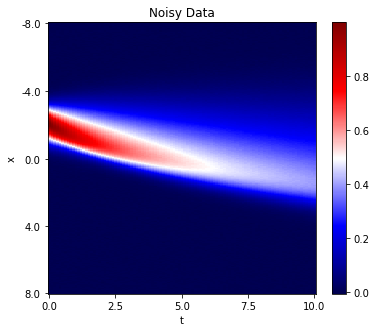

In [3]:
# Add noise
np.random.seed(0)
noise_level = 0.01
u = u.real + noise_level*np.std(u.real)*np.random.randn(u.shape[0],u.shape[1])

im = plt.imshow(u.real, cmap="seismic", aspect=0.4)
plt.colorbar(im)
plt.title("Noisy Data")
plt.xlabel("t")
plt.ylabel("x")

plt.xticks(xpos, t[xpos])
plt.yticks(ypos, ytick)
plt.gcf().set_size_inches(6,5)
plt.show()

In [4]:
# Prepare Training Data
xx, tt = np.meshgrid(x,t)
X = np.vstack([xx.ravel(), tt.ravel()]).T
print("X shape", X.shape)
print(X)

X shape (25856, 2)
[[-8.      0.    ]
 [-7.9375  0.    ]
 [-7.875   0.    ]
 ...
 [ 7.8125 10.    ]
 [ 7.875  10.    ]
 [ 7.9375 10.    ]]


In [5]:
y = np.zeros((u.size, 1), dtype=np.float)
for i,_x in enumerate(u.real.T):
    y[i*len(x):(i+1)*len(x)] = _x.reshape(len(x),1)
    
print("y shape", y.shape)


y shape (25856, 1)


In [6]:
# Setup Network
net = PINN(sizes=[2,20,20,20,1], activation=torch.nn.Tanh())
#print(net)

In [7]:
polynm = ['1', 'u', 'uˆ2']
spa_der = ['1', 'u_{x}', 'u_{xx}']
library_coeffs = pde_matrix_mul(polynm, spa_der)
print('library_coeffs:', library_coeffs)

tot_items = len(library_coeffs)
print('tot_items:', tot_items)

mask = torch.ones(tot_items, 1)
epochs = 10000

xi = nn.Parameter(torch.randn((tot_items, 1), requires_grad=True, device="cpu", dtype=torch.float32))
params = [{'params': net.parameters(), 'lr': 1e-3}, {'params': xi, 'lr': 1e-2}]

optimizer = Adam(params)
scheduler = ExponentialLR(optimizer, .9998)



library_coeffs: ['1', 'u_{x}', 'u_{xx}', 'u', 'uu_{x}', 'uu_{xx}', 'uˆ2', 'uˆ2u_{x}', 'uˆ2u_{xx}']
tot_items: 9


In [8]:
def model_identification(features, label, mask, poly_order, deriv_order):
    
    xi1 = []
    xi2 = []
    xi1_error_app = []
    xi2_error_app = []
    xi_update_app = []
    
    numbers = [0, 5, 26, 57, 73, 80, 95, 104, 129, 151]
    
    f1 = open("Results/Value_of_xi.txt", "w+", encoding="utf-8")
    f2 = open("Results/errors.txt", "w+", encoding="utf-8")
    f3 = open("Results/avg_xi_layer.txt", "a+", encoding="utf-8")
    correct_prediction = 0
    # Using for loop
    for i in numbers:
        np.random.seed(i)
        print('seed:', i)
        idxs = np.random.choice(y.size, 2000, replace=False)
        X_train = torch.tensor(features[idxs], dtype=torch.float32, requires_grad=True)
        y_train = torch.tensor(label[idxs], dtype=torch.float32)
    
        lamb   = 0
        tolerance = 1e-6
        mask = torch.ones(tot_items, 1)
        #print('xi', xi)
        print('mask:', mask.shape)
        lambd  = 1e-6
    
        for epoch in range(epochs):
            optimizer.zero_grad()
            uhat = net(X_train)
    
            if epoch == 1000:
                lamb = 1
               
            dudt, theta = construct_Dictonary(X_train, uhat, poly_order=2, deriv_order=2)
            #print('dudt:', dudt.shape)
            dudt_norm = torch.norm(dudt, dim=0)
    
            theta_scaling = (torch.norm(theta, dim=0))
            #Returns a new tensor with a dimension of size one inserted at the specified position. from 9 it will be 9,1
            theta_norm = torch.unsqueeze(theta_scaling, dim = 1) 
            xi_normalized = xi * (theta_norm / dudt_norm) 
            L1 = lambd * torch.sum(torch.abs(xi_normalized[1:, :]))
        
            l_u   = nn.MSELoss()(uhat, y_train)
            l_reg = lamb * torch.mean((dudt - theta @ xi)**2)
            #l_reg = torch.mean((dudt - theta @ xi)**2)

            loss = l_u + l_reg + L1

            gradient_loss = torch.max(torch.abs(grad(outputs=loss, inputs=xi, 
                  grad_outputs=torch.ones_like(loss), create_graph=True)[0]) / (theta_norm / dudt_norm))


            loss.backward(retain_graph=True)
            optimizer.step()
        
            if epoch % 1000 == 0:
                print('loss:', epoch, loss)
                if gradient_loss < tolerance:
                    print('Optimizer converged.')
                    break
 
        xi_list = sparse_coeff(mask, xi.detach().numpy())
        xi_normalized = sparse_coeff(mask, xi_normalized.detach().numpy())
        print('xi_normalized:', xi_normalized)
    

        sparsity = normalized_xi_threshold( xi_normalized, mode='auto')
        print('sparsity:', sparsity)
    
        xi_thresholded = np.expand_dims(xi_list[sparsity], axis=1) 
        print('xi_thresholded:', xi_thresholded)
        
        print('Coefficient xi:')
        xi_update = sparse_coeff(sparsity, xi_thresholded)
        print('xi_update:', xi_update)
        
    
        # Calculate Error in xi    
        if xi_update[2] != 0 and xi_update[4] != 0 and len(xi_thresholded) < 3:
            xi_update_app.append(xi_update)
            #print('xi_update_app:', xi_update_app)
            print('xi_update:', xi_update[2], xi_update[4])
            error_1 = np.subtract(np.array([0.10000]),xi_update[2])
            xi1_error = np.append(xi1, error_1)
            print('xi1_error', xi1_error)
            error_2 = np.subtract(np.array([1.00000]),np.abs(xi_update[4]))
            xi2_error = np.append(xi2, error_2)
            print('xi2_error', xi2_error)
            f1.write(str(xi_update[2]) + " " + str(xi_update[4]) + "\n")
            f2.write(str(xi1_error) + " " + str(xi2_error) + "\n")
            xi1_error_app.append(xi1_error)
            print('xi1_error_app:', xi1_error_app)
            xi2_error_app.append(xi2_error)
            print('xi2_error_app:', xi2_error_app)
            correct_prediction += 1
            
        else:
            print('PDE prediction not correct')
            
            
    print('correct_prediction:', correct_prediction)
    Accuracy = correct_prediction / len(numbers) * 100
    print('Accuracy:', Accuracy)
    xi1_error_avg = np.sum(xi1_error_app, axis = 0) / correct_prediction  
    print('xi1_error_avg:', xi1_error_avg)
    xi2_error_avg = np.sum(xi2_error_app, axis = 0) / correct_prediction 
    print('xi2_error_avg:', xi2_error_avg)
    xi_updated = np.sum(xi_update_app, axis = 0) / correct_prediction  
    print('xi_updated:', xi_updated)
    f3.write(str(xi_updated[2]) + " " + str(xi_updated[4]) + "\n")
    print('Finished')
    return xi_updated
                   

In [9]:
xi_updated = model_identification(X, y, mask, poly_order=2, deriv_order=2)


seed: 0
mask: torch.Size([9, 1])
loss: 0 tensor(0.0383, grad_fn=<AddBackward0>)
loss: 1000 tensor(1.3763, grad_fn=<AddBackward0>)
loss: 2000 tensor(0.0003, grad_fn=<AddBackward0>)
loss: 3000 tensor(0.0001, grad_fn=<AddBackward0>)
loss: 4000 tensor(6.2893e-05, grad_fn=<AddBackward0>)
loss: 5000 tensor(3.8599e-05, grad_fn=<AddBackward0>)
loss: 6000 tensor(2.6534e-05, grad_fn=<AddBackward0>)
loss: 7000 tensor(1.8749e-05, grad_fn=<AddBackward0>)
loss: 8000 tensor(1.3320e-05, grad_fn=<AddBackward0>)
loss: 9000 tensor(9.9246e-06, grad_fn=<AddBackward0>)
Optimizer converged.
xi_normalized: [[ 1.79669342e-03]
 [-3.41275670e-02]
 [ 3.82914722e-01]
 [ 3.08298692e-02]
 [-1.03878844e+00]
 [-5.20520152e-05]
 [-5.38632907e-02]
 [ 5.48183173e-02]
 [-1.69335976e-02]]
sparsity: [[False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]]
xi_thresholded: [[ 0.09394079]
 [-0.9895485 ]]
Coefficient xi:
xi_update: [[ 0.        ]
 [ 0.        ]
 [ 0.09394079]
 [ 0.        ]
 [-0.9895485

loss: 1000 tensor(0.0028, grad_fn=<AddBackward0>)
loss: 2000 tensor(5.4116e-06, grad_fn=<AddBackward0>)
loss: 3000 tensor(5.2143e-06, grad_fn=<AddBackward0>)
loss: 4000 tensor(5.0478e-06, grad_fn=<AddBackward0>)
loss: 5000 tensor(7.1124e-06, grad_fn=<AddBackward0>)
loss: 6000 tensor(5.3095e-06, grad_fn=<AddBackward0>)
loss: 7000 tensor(5.4409e-06, grad_fn=<AddBackward0>)
loss: 8000 tensor(4.8997e-06, grad_fn=<AddBackward0>)
loss: 9000 tensor(4.8926e-06, grad_fn=<AddBackward0>)
xi_normalized: [[ 9.27017769e-04]
 [-2.16860295e-04]
 [ 4.21770453e-01]
 [ 7.45834084e-04]
 [-1.00800633e+00]
 [-1.32540031e-03]
 [ 4.97448607e-04]
 [-6.78143115e-04]
 [-8.94970610e-04]]
sparsity: [[False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]]
xi_thresholded: [[ 0.10080618]
 [-0.99891251]]
Coefficient xi:
xi_update: [[ 0.        ]
 [ 0.        ]
 [ 0.10080618]
 [ 0.        ]
 [-0.99891251]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
xi_update: [0.10080618] [-0.9

In [10]:
pde_Recover(xi_updated, library_coeffs, equation_form='u_t')
end_time = datetime.now()
print('end_time:', end_time)
print('Duration: {}'.format(end_time - start_time))

Burger equation:
u_t = 0.0987u_{xx} - 0.9904uu_{x}
end_time: 2020-04-07 18:33:39.791667
Duration: 0:32:42.669763
